# Importing the Data
Performing attribute reduction by removing empty columns.

In [17]:
DATASET_DIR = './data/' # Datasets to be places here
# pip install pandas
# pip install xlrd

import os
import pandas as pd
import numpy as np

# removing empty columns and finding minimum and maximum scores given to each of the 8 sets

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
# reading from tsv file (tab - separated) with Latin alphabet encoding including special symbols
Y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
Z = pd.read_excel(r'./data/essay_set_descriptions.xlsx')

# minimum and maximum scores for each dataset
minimum_scores = Z['min_domain1_score'].to_list()
minimum_scores.insert(0,-1)
maximum_scores = Z['max_domain1_score'].to_list()
maximum_scores.insert(0,-1)
print('\n----------Essay Set Descriptions----------\n')
print(Z[['essay_set','type_of_essay','training_set_size']])

print('\nMinimum scores for each essay set:')
print(minimum_scores[1:9])
print('\nMaximum scores for each essay set:')
print(maximum_scores[1:9])


----------Essay Set Descriptions----------

   essay_set                         type_of_essay  training_set_size
0          1  persuasive / narrative  / expository               1783
1          2  persuasive / narrative  / expository               1800
2          3            source dependent responses               1726
3          4            source dependent responses               1772
4          5            source dependent responses               1805
5          6            source dependent responses               1800
6          7  persuasive / narrative  / expository               1569
7          8  persuasive / narrative  / expository                723

Minimum scores for each essay set:
[2, 1, 0, 0, 0, 0, 0, 0]

Maximum scores for each essay set:
[12, 6, 3, 3, 4, 4, 30, 60]


## Main Dataframe
Our main dataframe consists of 12975 sample essays which goes upto essay_id 21633 and are divided into 8 sets.

In [18]:
X

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35
12972,21628,8,I never understood the meaning laughter is th...,32
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,21630,8,Trippin' on fen...,40


## Pre-processing of the Data

These are all helper functions used to clean and tokenize the essays into sentences and wordlists.

In [19]:
# !pip install gensim for Word2vec and Fasttext Model
# !pip install nltk for natural Language Processing 

import nltk
# first time run download these packages
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('popular')

import re # for regular expressions operations 
from nltk.corpus import stopwords

def essay_to_wordlist(essay_v, remove_stopwords):
    # remove the tagged labels and word tokenize the sentence
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v) # removing anything that is not alphabetic
    words = essay_v.lower().split() # turn sentence into lowercase and split it into words 
    if remove_stopwords:
        stops = set(stopwords.words("english")) # english stopwords library 
        words = [w for w in words if not w in stops] 
        # words present in the sentence and not present in stopwords
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    # sentence tokenize the essay and call essay_to_wordlist() for word tokenization
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') # nltk library
    raw_sentences = tokenizer.tokenize(essay_v.strip()) # call tokenizer on essay striped of spaces 
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
            # remove_stopwords carried forward to essay_to_wordlist it is a bool variable
    return sentences # will be returning list of tokenized sentences without stopwords

def makeFeatureVec(words, model, num_features):
    # make Feature Vector from the words list of an Essay
    featureVec = np.zeros((num_features,),dtype="float32")
    #  make null vectors of length = num_features for every word index
    num_words = 0.
    index2word_set = set(model.wv.index2word) # vocabulary set of model
    for word in words:
        if word in index2word_set: # for word in a sentence being in index2word_set
            num_words += 1
            featureVec = np.add(featureVec,model.wv[word])
    if num_words:
        featureVec = np.divide(featureVec,num_words) 
        # divides every element of featureVec by num_words (to compute average) 
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    # main function to generate the word vectors for word2vec model
    # it then calls makeFeatureVec and for every essay sentance
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    # make null vectors of length = length of essay having null vector of num_features at every index
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs
    # then returns the trained model feature vectors

## Word embeddings
We will preprocess all essays and convert them to feature vectors using Word2vec and Fasttext model. We would also perform transfer learning by using pre-trained Word2vec, GloVe and Fasttext models.

All the word embeddings used are 300 dimentional vectors.

In [20]:
# initializing variables for word2vec and fasttext model.
num_features = 300 # vector length
min_word_count = 40 # to be considered for vectorisation
num_workers = 8 # working cores
context = 10
downsampling = 1e-3 # compressing

## Word2Vec Model
Using word2vec model to make embeddings for visualization.

In [21]:
from gensim.models import Word2Vec # for word2vec
from gensim.test.utils import get_tmpfile # for saving model

allsentences = [] # list of all sentences

for essay in X['essay']:
# obtaining all sentences from the essays.
    allsentences += essay_to_sentences(essay, remove_stopwords=True)

# for visualization of vectors
visualmodel = Word2Vec(
    allsentences, 
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context, 
    sample=downsampling
)

path = get_tmpfile("./word2vecvis/word2vecvisual.model") # path for the model 

visualmodel.init_sims(replace=True) # normalized model
# different ways to save model
visualmodel.wv.save_word2vec_format('./word2vecvis/word2vecvisual.txt', binary=False)
visualmodel.wv.save_word2vec_format('./word2vecvis/word2vecvisual.bin', binary=True)
visualmodel.save("./word2vecvis/word2vecvisual.model")

# embedding dataframe
M=visualmodel.wv[visualmodel.wv.vocab]
df=pd.DataFrame(M)
pd.options.display.max_columns=10
df

,0,1,2,3,4,...,295,296,297,298,299
0,-0.027145,-0.115765,-0.009457,0.107551,0.020552,...,0.141178,0.075063,0.016000,0.091417,-0.133742
1,-0.003566,-0.045941,0.009754,0.104737,-0.001699,...,0.050630,0.107837,-0.055656,0.072342,-0.136067
2,-0.005789,-0.108192,0.020309,0.109759,0.011063,...,0.112239,0.088852,0.010208,0.072229,-0.155145
3,-0.036672,-0.023025,0.153054,0.065163,0.008662,...,-0.137542,-0.016150,0.011479,-0.001463,-0.052557
4,0.011786,-0.049177,0.098266,0.055531,0.041913,...,0.068230,0.017671,0.099115,0.004832,-0.108978
...,...,...,...,...,...,...,...,...,...,...,...
2897,0.009593,-0.005689,0.008645,-0.084868,-0.012866,...,0.057447,0.036612,0.032315,0.015272,-0.010956
2898,-0.045176,-0.091832,0.092852,0.037899,0.058980,...,0.019672,0.072077,0.021747,0.002863,-0.089257
2899,-0.099686,-0.069520,0.041706,0.041269,0.079908,...,0.081380,0.073911,0.069235,-0.026248,-0.024912
2900,-0.073033,0.054120,-0.004177,0.036410,-0.019996,...,0.025915,0.059864,0.103031,0.012899,-0.001783


## Pre-Trained Word2Vec Model
It is trained on the Google News dataset (about 100 billion words).

In [22]:
from gensim.models import KeyedVectors

modelbasic = Word2Vec.load('./word2vecvis/word2vecvisual.model')
# getting embeddings from pretrained word2vec model 
modelbasic.intersect_word2vec_format('./word2vec/word2vec.bin', binary=True, lockf=1.0)

# will be using on training data
# modelbasic.train(allsentences,total_examples=len(allsentences), epochs=modelbasic.iter)
# modelbasic.init_sims(replace=True) # for normalizing
# modelbasic.save("./word2vec/word2vecPre.model")

## Pre-Trained Glove Model
It is trained on Wikipedia data and contains about 6 billion words in its vocabulary. 

In [23]:
from gensim.scripts.glove2word2vec import glove2word2vec

modelglove = Word2Vec.load('./word2vecvis/word2vecvisual.model')
# Converting Glove to Word2Vec
_ = glove2word2vec('./glove/glove.6B.300d.txt', "./glove/gloveW2V.txt")
# Getting embeddings from pretrained Glove model
modelglove.intersect_word2vec_format('./glove/gloveW2V.txt', binary=False, lockf=1.0)

# will be using on training data
# modelglove.train(allsentences,total_examples=len(allsentences), epochs=modelbasic.iter)
# modelglove.init_sims(replace=True) for normalizing
# modelglove.save("./glove/gloveW2V.model")

## Fasttext
It is similar to word2vec model but also contains embeddings for n-grams which hep in data sets with out of vocabulary words.

In [24]:
from gensim.models.fasttext import FastText

ftmodel = FastText(
    allsentences, 
    workers=num_workers, 
    size=num_features, 
    min_count = min_word_count, 
    window = context, 
    sample = downsampling
)
# ftmodel.save("./fasttext/fasttext.model") for saving with ngrams

# embedding dataframe
F=ftmodel.wv[ftmodel.wv.vocab]
ft=pd.DataFrame(F)
pd.options.display.max_columns=10
ft

,0,1,2,3,4,...,295,296,297,298,299
0,-0.203090,-1.810345,0.252627,0.754030,1.039290,...,0.782478,3.011457,-0.425950,-0.072408,-1.596914
1,-0.266696,-0.505383,0.150335,0.140612,1.033672,...,0.620165,0.259055,-0.484569,-0.076532,0.106989
2,-0.985629,-0.972171,0.292150,0.047145,0.992983,...,0.426324,0.589565,0.004484,0.496838,-0.799551
3,-1.050450,-0.189186,0.619276,1.297989,0.013050,...,-0.271437,0.367277,0.015112,0.188949,-0.843007
4,0.342775,0.405134,0.367749,-0.045337,0.491080,...,0.150076,1.146325,0.041547,-0.144602,-1.299305
...,...,...,...,...,...,...,...,...,...,...,...
2897,1.193032,0.089072,-0.582601,-0.788484,-0.581808,...,-0.419431,0.729760,0.029799,0.494471,-0.007322
2898,-0.129781,-0.527416,-0.065131,-0.025128,0.065893,...,-0.235609,0.101702,-0.071221,0.304766,0.098829
2899,0.411206,0.412775,-0.694911,-0.471891,-0.388837,...,0.363545,0.582925,-0.120574,-0.642625,0.122403
2900,0.333789,0.407109,-0.385736,-0.660157,0.522157,...,0.063434,-0.031626,0.453923,0.110149,0.057554


## Pre-Trained Fasttext Model
It is the fasttext model pre-trained on Wiki-news also containing sub-words data.

In [25]:
ftmodelPre = Word2Vec.load('./word2vecvis/word2vecvisual.model')
total_examples = ftmodelPre.corpus_count
# Getting embeddings from pretrained Fasttext model 
ftmodelPre.intersect_word2vec_format('./fasttext/wiki-news-300d-1M-subword.vec')

# will be using on training data
# ftmodelPre.train(allsentences,total_examples=len(allsentences), epochs=ftmodel.iter)
# ftmodelPre.save("./fasttext/fasttextPre.model") for saving with ngrams

## Visualization
Files needed for visualization on Embedding Projector, Tensorflow.

In [26]:
# Storing Visual model tsv files
import io # for input output

# files needed for tensorboard
out_v = io.open('./word2vecvis/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./word2vecvis/meta.tsv', 'w', encoding='utf-8')

# write meta file and vector file
for index in range(len(visualmodel.wv.index2word)): # for every word in vocab
    word = visualmodel.wv.index2word[index]
    vec = visualmodel.wv.vectors[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# Open http://projector.tensorflow.org/
# Click “Load Data” button from the left menu.
# Select “Choose file” in “Load a TSV file of vectors.” and choose “vecs.tsv” file.
# Select “Choose file” in “Load a TSV file of metadata.” and choose “meta.tsv” file.
# The model has been visualized in 3D/2D.
# It is done on choosing variable with higher variance as a dimension from the vector

## Exploratory Analysis
It is performed using Principal Component Analysis(PCA)


 300.0000000000004

1. Variance Explained
 [13.67892854995724, 10.575503075512751, 7.781089807175712, 7.101588128920885, 5.735317589149305]

2. Cumulative Variance Explained
 [13.67892855 24.25443163 32.03552143 39.13710956 44.87242715]

 [[-0.18805677  0.03612818]
 [-0.06617496  0.23679973]
 [-0.26259447  0.24494016]
 ...
 [ 0.53815327  0.22873941]
 [ 0.43147991  0.17508717]
 [ 0.08471955  0.09897139]]


<BarContainer object of 5 artists>

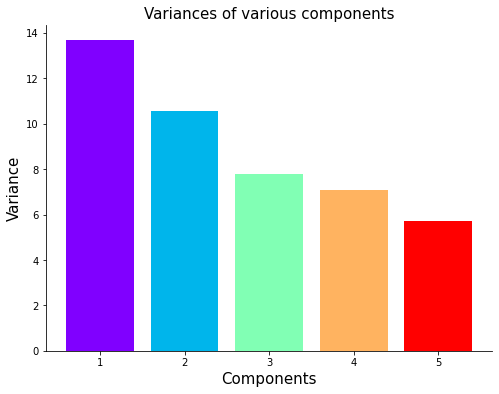

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Computing the correlation matrix
M_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(M_corr)


# Sorting the eigen vectors coresponding to eigen values in descending order is done like 
# this to have us choosing best eigenvector for infogain. But in our model its already 
# sorted the way it should be. Eigenvector with highest eigenvalue in the first column.
# args = (-values).argsort()
# values = vectors[args]
# vectors = vectors[:, args]

# our aim is to cover maximum variance possible 
# no. of components selected = no. of plotting dimensions
tot = sum(values) # summation of eigenvalues
print("\n",tot) 
var_exp = [(i / tot)*100 for i in values[:5]] # first 5 variance in desc order
print("\n1. Variance Explained\n",var_exp) 
cum_var_exp = np.cumsum(var_exp) # first 5 cumulative variance
print("\n2. Cumulative Variance Explained\n",cum_var_exp) 

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

new_M=np.dot(M,new_vectors)
print("\n",new_M) # coordinates for 2D plot

plt.figure(figsize=(8,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Variances of various components',size=15)
plt.xlabel("Components",size=15)
plt.ylabel('Variance',size=15)
plt.bar(range(1,6),
        var_exp,
        width=0.8,
        color = cm.rainbow(np.linspace(0, 1, len(var_exp))))

## Word Embedding Plot
Using PCA we have done plotting of the vectors in a 2-dimentional space 

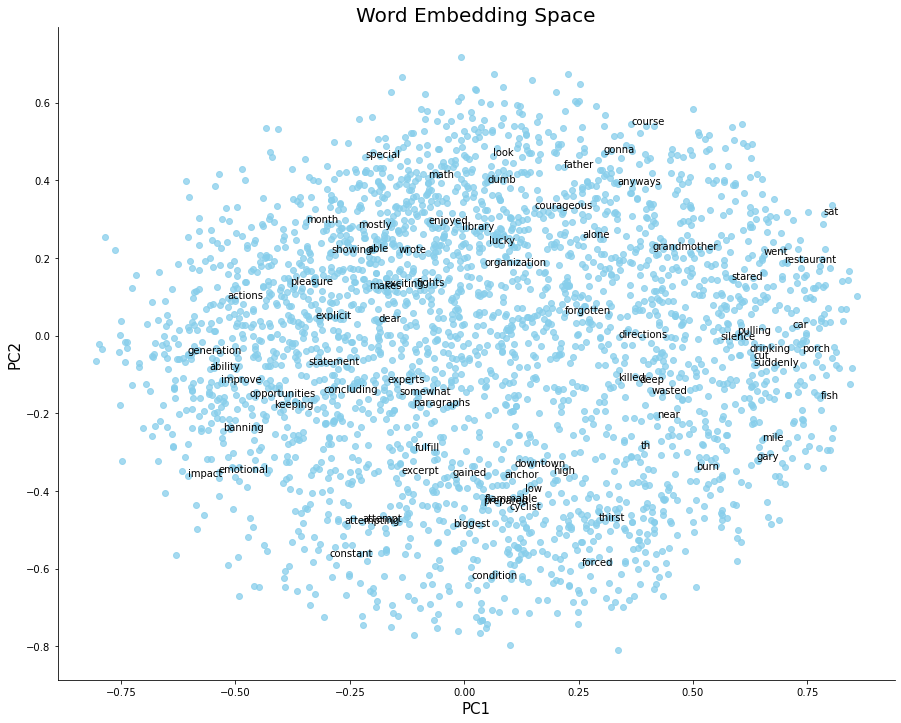

In [28]:
#Plotting
plt.figure(figsize=(15,12))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(new_M[:,0],new_M[:,1],linewidths=1,color='skyblue',alpha=0.75)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(visualmodel.wv.vocab)
for i, word in enumerate(vocab):
  if i%37==0:
      plt.annotate(word,xy=(new_M[i,0],new_M[i,1])) # selective annotations
  

## Defining the model 
We have used three types of models namely:
Dual layer LSTM, Bi-directional LSTM, Convolutional neural network LSTM

In [29]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D
from keras.models import Sequential
import keras.backend as K

# bidirectional is for evaluating input in both sequential order
# conv1D is for adding a Cnn layer instead of a LSTM layer
# return sequences return sequences in shape for next Lstm layer
# dropout layers are for regularization
# dropout is for inputs and recurrent dropout is for recurrent inputs
# instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.
# x is 0-> Dual layer LSTM, 1-> Bidirectional LSTM, 2-> CNN LSTM 

def get_model(x):
    model = Sequential()
    if x == 0:
        model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    if x == 1:
        model.add(Bidirectional(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True)))
    if x == 2:
        model.add(Conv1D(64, 3, activation='relu',input_shape=(1,300),padding='same'))
        model.add(Dropout(0.4))
    model.add(LSTM(128, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    if x == 1:
        model.build((None,1,300))
    model.summary()
    return model

## Training Phase
Here we will train our data for 5 types of word embeddings and 3 types of LSTM Networks. And store the respective Kappa Scores in the dataframe and them will do comparative analysis.


Shape of X_train and y_train respectively.

(9083, 4) (9083,)
(3893, 4) (3893,)

------------------- Dual-LSTM Model with W2V Embeddings -------------------

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_26 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] - 4s 15ms/step - loss: 48.3631 - 

Epoch 54/100
284/284 [==============================] - 4s 14ms/step - loss: 5.5258 - mae: 1.3258 - val_loss: 5.3129 - val_mae: 1.2545
Epoch 55/100
284/284 [==============================] - 4s 14ms/step - loss: 5.7077 - mae: 1.3231 - val_loss: 5.2734 - val_mae: 1.2517
Epoch 56/100
284/284 [==============================] - 4s 15ms/step - loss: 5.7781 - mae: 1.3444 - val_loss: 5.2196 - val_mae: 1.2425
Epoch 57/100
284/284 [==============================] - 4s 14ms/step - loss: 5.7223 - mae: 1.3236 - val_loss: 5.3048 - val_mae: 1.2479
Epoch 58/100
284/284 [==============================] - 4s 14ms/step - loss: 5.4956 - mae: 1.3129 - val_loss: 5.1726 - val_mae: 1.2366
Epoch 59/100
284/284 [==============================] - 4s 15ms/step - loss: 5.4702 - mae: 1.3113 - val_loss: 5.2640 - val_mae: 1.2448
Epoch 60/100
284/284 [==============================] - 4s 14ms/step - loss: 5.3701 - mae: 1.3144 - val_loss: 5.1188 - val_mae: 1.2301
Epoch 61/100
284/284 [==============================] -

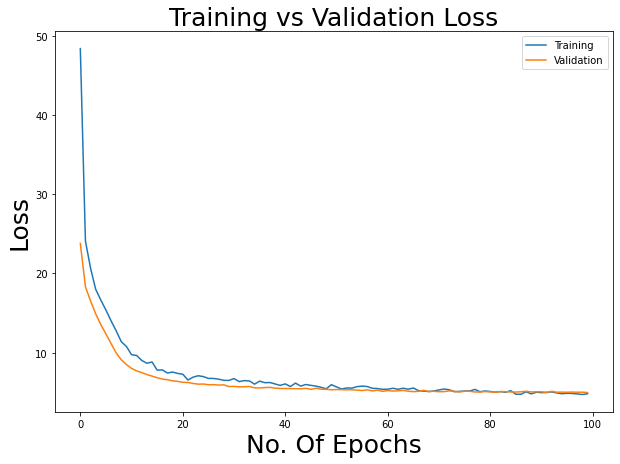


Kappa Score: 0.9664988323312314

------------------- Dual-LSTM Model with W2V Embeddings -------------------


------------------- Bi-LSTM Model with W2V Embeddings -------------------

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_28 (LSTM)               (None, 128)               373248    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] -

284/284 [==============================] - 7s 25ms/step - loss: 5.0148 - mae: 1.2850 - val_loss: 5.0433 - val_mae: 1.2058
Epoch 54/100
284/284 [==============================] - 7s 25ms/step - loss: 5.2960 - mae: 1.3001 - val_loss: 5.0646 - val_mae: 1.2008
Epoch 55/100
284/284 [==============================] - 7s 25ms/step - loss: 5.0633 - mae: 1.2807 - val_loss: 5.0088 - val_mae: 1.2027
Epoch 56/100
284/284 [==============================] - 7s 25ms/step - loss: 5.0631 - mae: 1.2823 - val_loss: 5.0631 - val_mae: 1.2130
Epoch 57/100
284/284 [==============================] - 7s 25ms/step - loss: 5.2357 - mae: 1.2802 - val_loss: 5.0777 - val_mae: 1.2044
Epoch 58/100
284/284 [==============================] - 7s 25ms/step - loss: 5.1288 - mae: 1.2886 - val_loss: 5.0746 - val_mae: 1.2062
Epoch 59/100
284/284 [==============================] - 7s 25ms/step - loss: 5.1654 - mae: 1.2822 - val_loss: 5.0039 - val_mae: 1.2030
Epoch 60/100
284/284 [==============================] - 7s 25ms/step

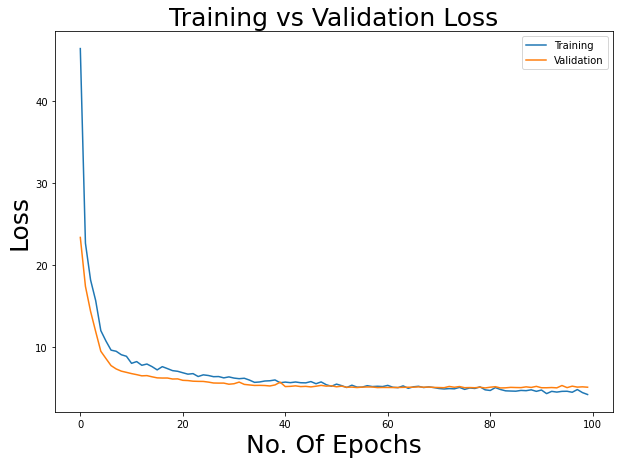


Kappa Score: 0.9651027398863934

------------------- Bi-LSTM Model with W2V Embeddings -------------------


------------------- Cnn-LSTM Model with W2V Embeddings -------------------

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_22 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainable par

284/284 [==============================] - 1s 4ms/step - loss: 7.0680 - mae: 1.4914 - val_loss: 6.3203 - val_mae: 1.3588
Epoch 54/100
284/284 [==============================] - 1s 4ms/step - loss: 6.9406 - mae: 1.4760 - val_loss: 6.2784 - val_mae: 1.3396
Epoch 55/100
284/284 [==============================] - 1s 4ms/step - loss: 6.7325 - mae: 1.4581 - val_loss: 6.2253 - val_mae: 1.3325
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 6.8170 - mae: 1.4615 - val_loss: 6.3337 - val_mae: 1.3342
Epoch 57/100
284/284 [==============================] - 1s 4ms/step - loss: 6.4452 - mae: 1.4398 - val_loss: 6.3072 - val_mae: 1.3499
Epoch 58/100
284/284 [==============================] - 1s 4ms/step - loss: 6.6820 - mae: 1.4513 - val_loss: 6.2816 - val_mae: 1.3398
Epoch 59/100
284/284 [==============================] - 1s 4ms/step - loss: 6.5964 - mae: 1.4420 - val_loss: 6.2763 - val_mae: 1.3364
Epoch 60/100
284/284 [==============================] - 1s 4ms/step - loss:

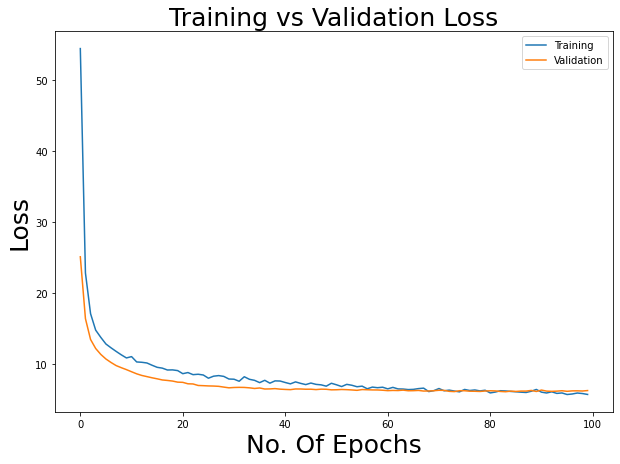


Kappa Score: 0.9590740159828054

------------------- Cnn-LSTM Model with W2V Embeddings -------------------


------------------- Dual-LSTM Model with W2VP Embeddings -------------------

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_31 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] - 4

284/284 [==============================] - 4s 14ms/step - loss: 5.2170 - mae: 1.3187 - val_loss: 4.9318 - val_mae: 1.2281
Epoch 54/100
284/284 [==============================] - 4s 14ms/step - loss: 5.2298 - mae: 1.3109 - val_loss: 4.8089 - val_mae: 1.2193
Epoch 55/100
284/284 [==============================] - 4s 15ms/step - loss: 5.1750 - mae: 1.2940 - val_loss: 4.6987 - val_mae: 1.2064
Epoch 56/100
284/284 [==============================] - 4s 14ms/step - loss: 5.1583 - mae: 1.3012 - val_loss: 4.7796 - val_mae: 1.2128
Epoch 57/100
284/284 [==============================] - 4s 14ms/step - loss: 5.2481 - mae: 1.3045 - val_loss: 4.7959 - val_mae: 1.2226
Epoch 58/100
284/284 [==============================] - 4s 14ms/step - loss: 5.0720 - mae: 1.2915 - val_loss: 4.7317 - val_mae: 1.2036
Epoch 59/100
284/284 [==============================] - 4s 14ms/step - loss: 4.8140 - mae: 1.2726 - val_loss: 4.8253 - val_mae: 1.2078
Epoch 60/100
284/284 [==============================] - 4s 14ms/step

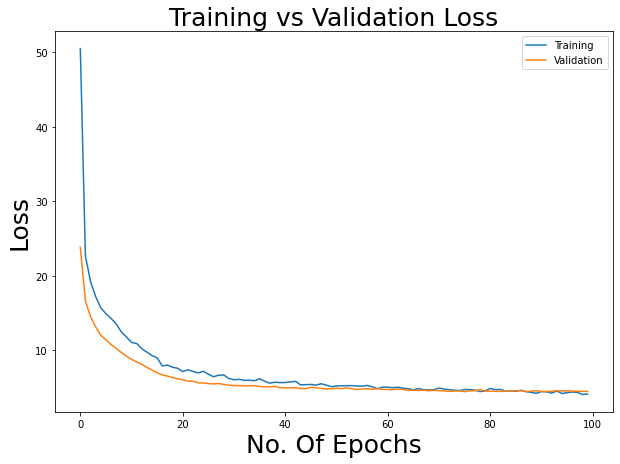


Kappa Score: 0.9701962649505977

------------------- Dual-LSTM Model with W2VP Embeddings -------------------


------------------- Bi-LSTM Model with W2VP Embeddings -------------------

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_33 (LSTM)               (None, 128)               373248    
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================]

284/284 [==============================] - 7s 24ms/step - loss: 4.3993 - mae: 1.2219 - val_loss: 4.4355 - val_mae: 1.1616
Epoch 54/100
284/284 [==============================] - 7s 24ms/step - loss: 4.5659 - mae: 1.2463 - val_loss: 4.3482 - val_mae: 1.1573
Epoch 55/100
284/284 [==============================] - 7s 24ms/step - loss: 4.6793 - mae: 1.2363 - val_loss: 4.4422 - val_mae: 1.1562
Epoch 56/100
284/284 [==============================] - 7s 26ms/step - loss: 4.5594 - mae: 1.2417 - val_loss: 4.3546 - val_mae: 1.1609
Epoch 57/100
284/284 [==============================] - 7s 24ms/step - loss: 4.4090 - mae: 1.2287 - val_loss: 4.4586 - val_mae: 1.1663
Epoch 58/100
284/284 [==============================] - 7s 24ms/step - loss: 4.3842 - mae: 1.2151 - val_loss: 4.4831 - val_mae: 1.1594
Epoch 59/100
284/284 [==============================] - 7s 24ms/step - loss: 4.3468 - mae: 1.2286 - val_loss: 4.4364 - val_mae: 1.1608
Epoch 60/100
284/284 [==============================] - 7s 24ms/step

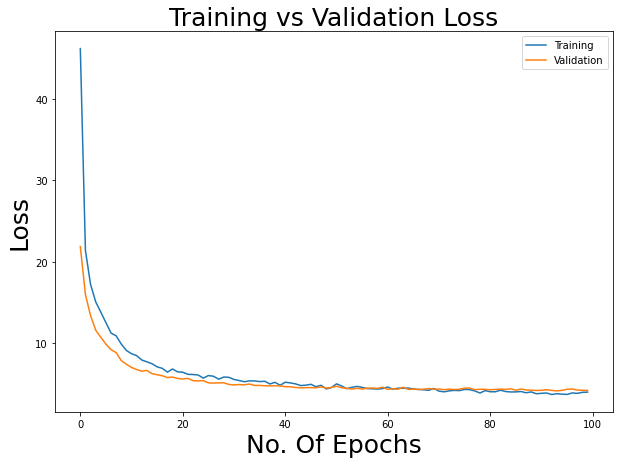


Kappa Score: 0.9715123669761992

------------------- Bi-LSTM Model with W2VP Embeddings -------------------


------------------- Cnn-LSTM Model with W2VP Embeddings -------------------

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_26 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainable p

284/284 [==============================] - 1s 4ms/step - loss: 5.1903 - mae: 1.3163 - val_loss: 6.0594 - val_mae: 1.2804
Epoch 54/100
284/284 [==============================] - 1s 4ms/step - loss: 5.2006 - mae: 1.3148 - val_loss: 6.0517 - val_mae: 1.2807
Epoch 55/100
284/284 [==============================] - 1s 4ms/step - loss: 4.9033 - mae: 1.2919 - val_loss: 6.0650 - val_mae: 1.2827
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 5.2829 - mae: 1.3261 - val_loss: 6.1133 - val_mae: 1.2866
Epoch 57/100
284/284 [==============================] - 1s 4ms/step - loss: 4.9735 - mae: 1.2864 - val_loss: 6.1288 - val_mae: 1.2871
Epoch 58/100
284/284 [==============================] - 1s 4ms/step - loss: 5.1930 - mae: 1.3014 - val_loss: 6.1809 - val_mae: 1.2890
Epoch 59/100
284/284 [==============================] - 1s 4ms/step - loss: 5.0980 - mae: 1.3028 - val_loss: 6.1470 - val_mae: 1.2862
Epoch 60/100
284/284 [==============================] - 1s 4ms/step - loss:

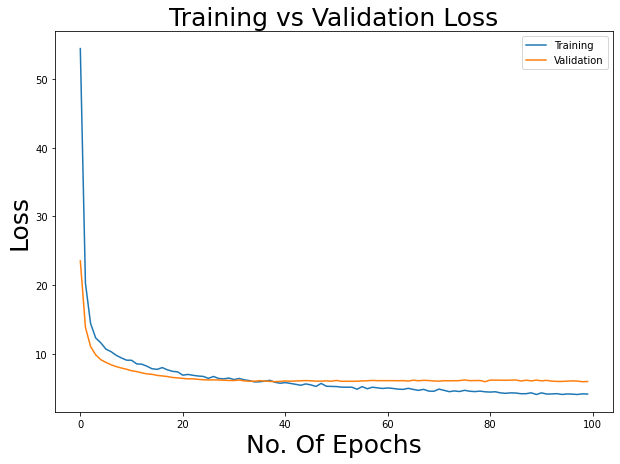


Kappa Score: 0.9595862098604782

------------------- Cnn-LSTM Model with W2VP Embeddings -------------------


------------------- Dual-LSTM Model with GloVe Embeddings -------------------

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_36 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] -

284/284 [==============================] - 4s 15ms/step - loss: 5.1711 - mae: 1.3180 - val_loss: 4.8711 - val_mae: 1.2363
Epoch 54/100
284/284 [==============================] - 4s 15ms/step - loss: 5.2574 - mae: 1.3214 - val_loss: 4.8301 - val_mae: 1.2296
Epoch 55/100
284/284 [==============================] - 4s 15ms/step - loss: 5.2277 - mae: 1.3184 - val_loss: 4.7703 - val_mae: 1.2261
Epoch 56/100
284/284 [==============================] - 4s 16ms/step - loss: 5.3548 - mae: 1.3387 - val_loss: 4.8457 - val_mae: 1.2215
Epoch 57/100
284/284 [==============================] - 4s 16ms/step - loss: 5.1987 - mae: 1.3183 - val_loss: 4.8120 - val_mae: 1.2236
Epoch 58/100
284/284 [==============================] - 4s 15ms/step - loss: 5.0599 - mae: 1.3008 - val_loss: 4.7648 - val_mae: 1.2168
Epoch 59/100
284/284 [==============================] - 4s 15ms/step - loss: 5.2877 - mae: 1.3105 - val_loss: 4.7451 - val_mae: 1.2132
Epoch 60/100
284/284 [==============================] - 4s 15ms/step

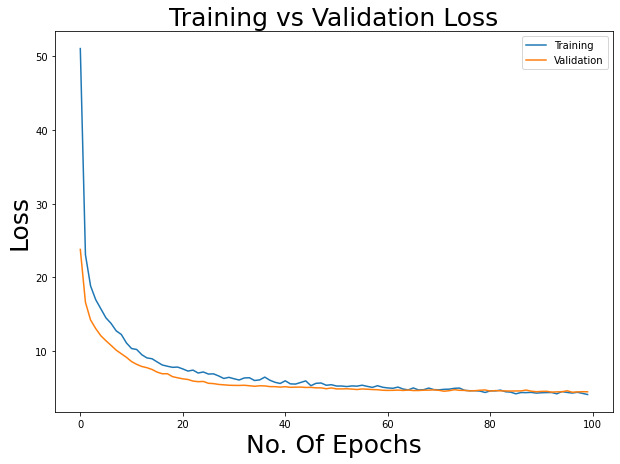


Kappa Score: 0.9699869692230054

------------------- Dual-LSTM Model with GloVe Embeddings -------------------


------------------- Bi-LSTM Model with GloVe Embeddings -------------------

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_38 (LSTM)               (None, 128)               373248    
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [=============================

284/284 [==============================] - 9s 32ms/step - loss: 4.8449 - mae: 1.2601 - val_loss: 4.3644 - val_mae: 1.1572
Epoch 54/100
284/284 [==============================] - 10s 34ms/step - loss: 4.5921 - mae: 1.2352 - val_loss: 4.3771 - val_mae: 1.1605
Epoch 55/100
284/284 [==============================] - 8s 27ms/step - loss: 4.9393 - mae: 1.2720 - val_loss: 4.3563 - val_mae: 1.1573
Epoch 56/100
284/284 [==============================] - 9s 31ms/step - loss: 4.5027 - mae: 1.2434 - val_loss: 4.4341 - val_mae: 1.1627
Epoch 57/100
284/284 [==============================] - 10s 34ms/step - loss: 4.6094 - mae: 1.2422 - val_loss: 4.3476 - val_mae: 1.1529
Epoch 58/100
284/284 [==============================] - 9s 31ms/step - loss: 4.5581 - mae: 1.2313 - val_loss: 4.5502 - val_mae: 1.1618
Epoch 59/100
284/284 [==============================] - 8s 29ms/step - loss: 4.4053 - mae: 1.2238 - val_loss: 4.6007 - val_mae: 1.1757
Epoch 60/100
284/284 [==============================] - 8s 27ms/st

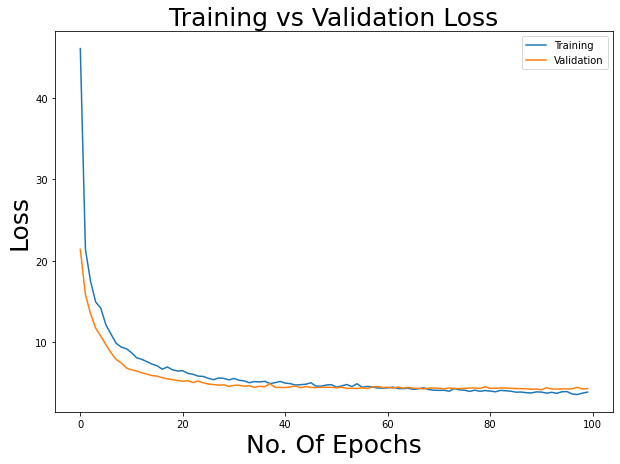


Kappa Score: 0.9702974448488983

------------------- Bi-LSTM Model with GloVe Embeddings -------------------


------------------- Cnn-LSTM Model with GloVe Embeddings -------------------

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_30 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainable

284/284 [==============================] - 2s 5ms/step - loss: 5.0031 - mae: 1.3043 - val_loss: 5.9403 - val_mae: 1.2645
Epoch 54/100
284/284 [==============================] - 1s 4ms/step - loss: 4.9049 - mae: 1.2911 - val_loss: 6.0117 - val_mae: 1.2670
Epoch 55/100
284/284 [==============================] - 1s 4ms/step - loss: 4.9453 - mae: 1.2980 - val_loss: 5.9745 - val_mae: 1.2591
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 5.1185 - mae: 1.3179 - val_loss: 5.9246 - val_mae: 1.2611
Epoch 57/100
284/284 [==============================] - 1s 5ms/step - loss: 4.8979 - mae: 1.2863 - val_loss: 5.9711 - val_mae: 1.2634
Epoch 58/100
284/284 [==============================] - 1s 5ms/step - loss: 4.9374 - mae: 1.2891 - val_loss: 5.9041 - val_mae: 1.2599
Epoch 59/100
284/284 [==============================] - 1s 4ms/step - loss: 4.8681 - mae: 1.2828 - val_loss: 5.9502 - val_mae: 1.2554
Epoch 60/100
284/284 [==============================] - 1s 4ms/step - loss:

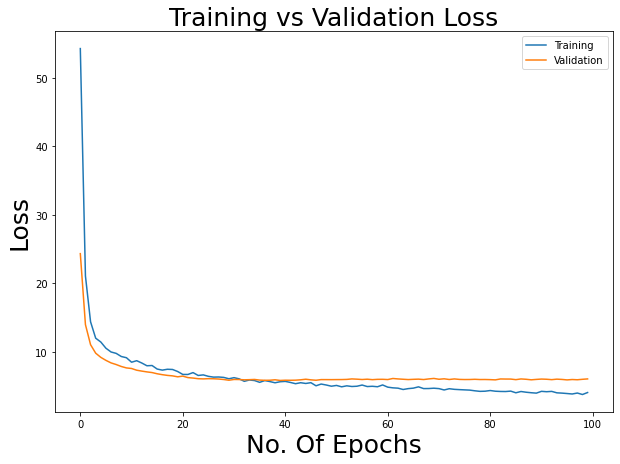


Kappa Score: 0.960292270838655

------------------- Cnn-LSTM Model with GloVe Embeddings -------------------


------------------- Dual-LSTM Model with FsTxT Embeddings -------------------

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_41 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] -

284/284 [==============================] - 4s 15ms/step - loss: 5.7298 - mae: 1.3810 - val_loss: 5.4503 - val_mae: 1.2926
Epoch 54/100
284/284 [==============================] - 4s 15ms/step - loss: 6.0396 - mae: 1.3919 - val_loss: 5.5072 - val_mae: 1.2941
Epoch 55/100
284/284 [==============================] - 4s 14ms/step - loss: 5.6157 - mae: 1.3710 - val_loss: 5.5059 - val_mae: 1.2987
Epoch 56/100
284/284 [==============================] - 4s 14ms/step - loss: 5.8193 - mae: 1.3737 - val_loss: 5.5083 - val_mae: 1.2934
Epoch 57/100
284/284 [==============================] - 4s 14ms/step - loss: 5.5875 - mae: 1.3596 - val_loss: 5.3822 - val_mae: 1.2821
Epoch 58/100
284/284 [==============================] - 4s 15ms/step - loss: 5.4841 - mae: 1.3533 - val_loss: 5.3701 - val_mae: 1.2789
Epoch 59/100
284/284 [==============================] - 4s 14ms/step - loss: 5.6303 - mae: 1.3599 - val_loss: 5.4753 - val_mae: 1.2918
Epoch 60/100
284/284 [==============================] - 4s 14ms/step

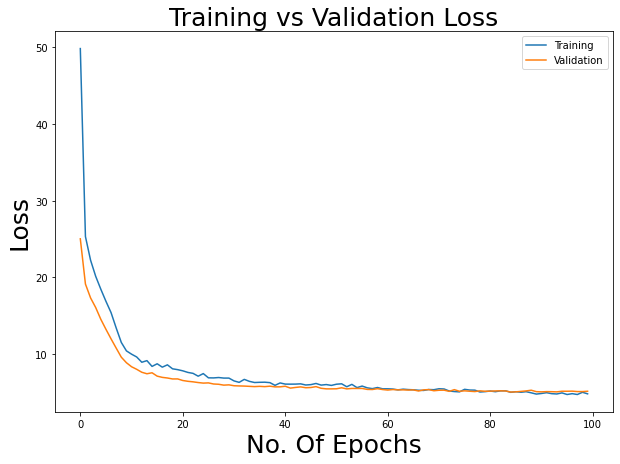


Kappa Score: 0.9645360260905763

------------------- Dual-LSTM Model with FsTxT Embeddings -------------------


------------------- Bi-LSTM Model with FsTxT Embeddings -------------------

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_43 (LSTM)               (None, 128)               373248    
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [=============================

284/284 [==============================] - 10s 35ms/step - loss: 5.2067 - mae: 1.3294 - val_loss: 5.2007 - val_mae: 1.2575
Epoch 54/100
284/284 [==============================] - 10s 35ms/step - loss: 5.1642 - mae: 1.3180 - val_loss: 5.4193 - val_mae: 1.2765
Epoch 55/100
284/284 [==============================] - 10s 35ms/step - loss: 5.0189 - mae: 1.2935 - val_loss: 5.2781 - val_mae: 1.2607
Epoch 56/100
284/284 [==============================] - 10s 35ms/step - loss: 5.1062 - mae: 1.3119 - val_loss: 5.3453 - val_mae: 1.2643
Epoch 57/100
284/284 [==============================] - 9s 32ms/step - loss: 4.9186 - mae: 1.2989 - val_loss: 5.5659 - val_mae: 1.2827
Epoch 58/100
284/284 [==============================] - 8s 27ms/step - loss: 5.1229 - mae: 1.3105 - val_loss: 5.1860 - val_mae: 1.2510
Epoch 59/100
284/284 [==============================] - 8s 27ms/step - loss: 5.0846 - mae: 1.3133 - val_loss: 5.2147 - val_mae: 1.2489
Epoch 60/100
284/284 [==============================] - 8s 27ms/

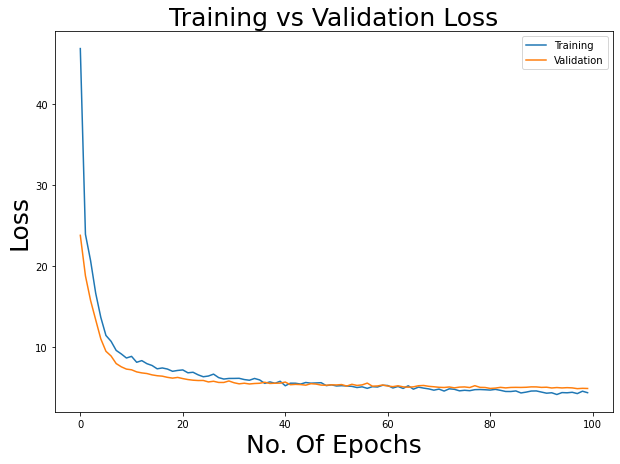


Kappa Score: 0.9666425022824016

------------------- Bi-LSTM Model with FsTxT Embeddings -------------------


------------------- Cnn-LSTM Model with FsTxT Embeddings -------------------

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_34 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainable

284/284 [==============================] - 1s 4ms/step - loss: 6.4929 - mae: 1.4346 - val_loss: 6.2749 - val_mae: 1.3306
Epoch 54/100
284/284 [==============================] - 1s 4ms/step - loss: 6.8246 - mae: 1.4492 - val_loss: 6.2590 - val_mae: 1.3271
Epoch 55/100
284/284 [==============================] - 1s 4ms/step - loss: 6.6853 - mae: 1.4554 - val_loss: 6.2807 - val_mae: 1.3299
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 6.4127 - mae: 1.4312 - val_loss: 6.3968 - val_mae: 1.3312
Epoch 57/100
284/284 [==============================] - 1s 4ms/step - loss: 6.4561 - mae: 1.4377 - val_loss: 6.2748 - val_mae: 1.3283
Epoch 58/100
284/284 [==============================] - 1s 4ms/step - loss: 6.2742 - mae: 1.4218 - val_loss: 6.2048 - val_mae: 1.3302
Epoch 59/100
284/284 [==============================] - 1s 4ms/step - loss: 6.1467 - mae: 1.4052 - val_loss: 6.4411 - val_mae: 1.3445
Epoch 60/100
284/284 [==============================] - 1s 4ms/step - loss:

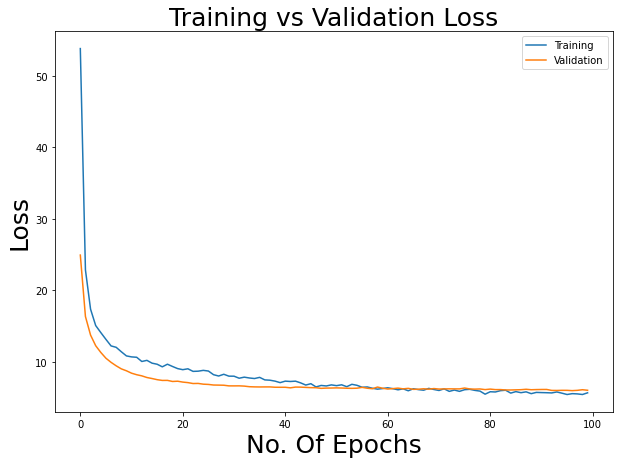


Kappa Score: 0.9601456974510371

------------------- Cnn-LSTM Model with FsTxT Embeddings -------------------


------------------- Dual-LSTM Model with FsTxTP Embeddings -------------------

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_46 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================]

284/284 [==============================] - 4s 15ms/step - loss: 8.7008 - mae: 1.6682 - val_loss: 6.6793 - val_mae: 1.4364
Epoch 54/100
284/284 [==============================] - 4s 15ms/step - loss: 9.0960 - mae: 1.6735 - val_loss: 6.3948 - val_mae: 1.4049
Epoch 55/100
284/284 [==============================] - 4s 15ms/step - loss: 8.5882 - mae: 1.6359 - val_loss: 6.5106 - val_mae: 1.4190
Epoch 56/100
284/284 [==============================] - 4s 15ms/step - loss: 8.8123 - mae: 1.6562 - val_loss: 6.6323 - val_mae: 1.4267
Epoch 57/100
284/284 [==============================] - 4s 15ms/step - loss: 8.5692 - mae: 1.6435 - val_loss: 6.4102 - val_mae: 1.4092
Epoch 58/100
284/284 [==============================] - 5s 17ms/step - loss: 8.3403 - mae: 1.6408 - val_loss: 6.6011 - val_mae: 1.4196
Epoch 59/100
284/284 [==============================] - 5s 17ms/step - loss: 8.8969 - mae: 1.6452 - val_loss: 6.4230 - val_mae: 1.4174
Epoch 60/100
284/284 [==============================] - 4s 15ms/step

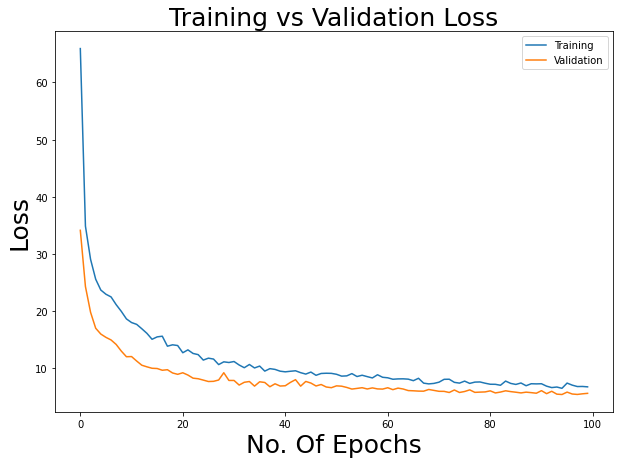


Kappa Score: 0.9621598726481022

------------------- Dual-LSTM Model with FsTxTP Embeddings -------------------


------------------- Bi-LSTM Model with FsTxTP Embeddings -------------------

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_48 (LSTM)               (None, 128)               373248    
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [===========================

284/284 [==============================] - 7s 26ms/step - loss: 7.4313 - mae: 1.5136 - val_loss: 5.7248 - val_mae: 1.2998
Epoch 54/100
284/284 [==============================] - 7s 26ms/step - loss: 6.6078 - mae: 1.4669 - val_loss: 6.0171 - val_mae: 1.3263
Epoch 55/100
284/284 [==============================] - 7s 26ms/step - loss: 6.8014 - mae: 1.4739 - val_loss: 5.5955 - val_mae: 1.2884
Epoch 56/100
284/284 [==============================] - 8s 28ms/step - loss: 7.1501 - mae: 1.4915 - val_loss: 6.3671 - val_mae: 1.3519
Epoch 57/100
284/284 [==============================] - 7s 26ms/step - loss: 7.0408 - mae: 1.5086 - val_loss: 5.3530 - val_mae: 1.2746
Epoch 58/100
284/284 [==============================] - 7s 26ms/step - loss: 6.6471 - mae: 1.4605 - val_loss: 5.3005 - val_mae: 1.2699
Epoch 59/100
284/284 [==============================] - 7s 26ms/step - loss: 7.0286 - mae: 1.4912 - val_loss: 5.7319 - val_mae: 1.2982
Epoch 60/100
284/284 [==============================] - 7s 26ms/step

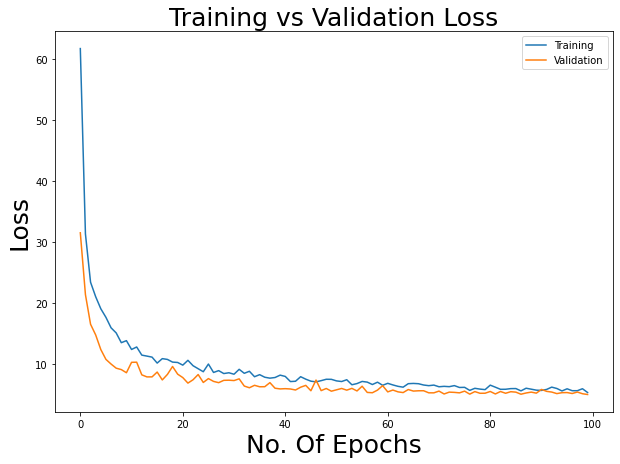


Kappa Score: 0.9657750325410783

------------------- Bi-LSTM Model with FsTxTP Embeddings -------------------


------------------- Cnn-LSTM Model with FsTxTP Embeddings -------------------

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_38 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainab

Epoch 53/100
284/284 [==============================] - 1s 4ms/step - loss: 6.9982 - mae: 1.5278 - val_loss: 7.5386 - val_mae: 1.4722
Epoch 54/100
284/284 [==============================] - 1s 4ms/step - loss: 7.1063 - mae: 1.5194 - val_loss: 7.9020 - val_mae: 1.4856
Epoch 55/100
284/284 [==============================] - 1s 4ms/step - loss: 6.8584 - mae: 1.5187 - val_loss: 7.3989 - val_mae: 1.4403
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 7.1174 - mae: 1.5353 - val_loss: 7.9206 - val_mae: 1.4880
Epoch 57/100
284/284 [==============================] - 1s 4ms/step - loss: 7.1317 - mae: 1.5286 - val_loss: 7.3670 - val_mae: 1.4324
Epoch 58/100
284/284 [==============================] - 1s 4ms/step - loss: 6.7221 - mae: 1.4844 - val_loss: 7.1458 - val_mae: 1.4117
Epoch 59/100
284/284 [==============================] - 1s 4ms/step - loss: 6.7236 - mae: 1.4937 - val_loss: 7.5856 - val_mae: 1.4454
Epoch 60/100
284/284 [==============================] - 1s 4ms

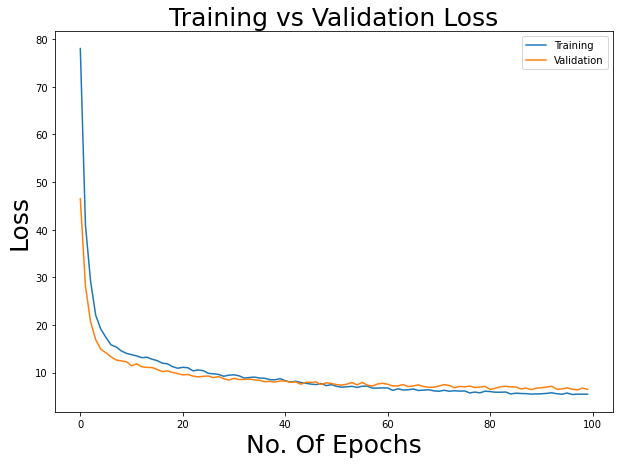


Kappa Score: 0.9573625650071591

------------------- Cnn-LSTM Model with FsTxTP Embeddings -------------------



In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
    
X_train,X_test,y_train,y_test = train_test_split(X, Y, train_size=0.70,test_size=0.30, random_state=0)
print('\nShape of X_train and y_train respectively.\n')
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
    
train_essays = X_train['essay']
test_essays = X_test['essay']
   
sentences = []
    
for essay in train_essays:
    # Obtaining all sentences from the training essays.
    sentences += essay_to_sentences(essay, remove_stopwords = True)

models = ['Dual-LSTM','Bi-LSTM','Cnn-LSTM']
embeddings = ['W2V','W2VP','GloVe','FsTxT','FsTxTP']

# dataframe to store our final result
final = {
    embeddings[0]:{models[0]:0,models[1]:0,models[2]:0},
    embeddings[1]:{models[0]:0,models[1]:0,models[2]:0},
    embeddings[2]:{models[0]:0,models[1]:0,models[2]:0},
    embeddings[3]:{models[0]:0,models[1]:0,models[2]:0},
    embeddings[4]:{models[0]:0,models[1]:0,models[2]:0}     
}

for i in range(5): # for every word embedding
    
    if(i==0):
        model = Word2Vec(
            sentences, 
            workers=num_workers, 
            size=num_features, 
            min_count = min_word_count, 
            window = context, 
            sample = downsampling
        )
        model.init_sims(replace=True) # for normalizing
    
    if(i==1):
        model = modelbasic
        modelbasic.train(allsentences,total_examples=len(allsentences), epochs=modelbasic.epochs)
        modelbasic.init_sims(replace=True) # for normalizing
        modelbasic.save("./word2vec/word2vecPre.model") # saving model
        model.train(sentences,total_examples=len(sentences), epochs=model.epochs)
        model.init_sims(replace=True) # for normalizing
    
    if(i==2):
        model = modelglove
        modelglove.train(allsentences,total_examples=len(allsentences), epochs=modelbasic.epochs)
        modelglove.init_sims(replace=True) # for normalizing
        modelglove.save("./glove/gloveW2V.model") # saving model
        model.train(sentences,total_examples=len(sentences), epochs=model.epochs)
        model.init_sims(replace=True) # for normalizing
    
    if(i==3):
        model = FastText(
            sentences, 
            workers=num_workers, 
            size=num_features, 
            min_count = min_word_count, 
            window = context, 
            sample = downsampling
        )
        model.init_sims(replace=True) # for normalizing
    
    if(i==4):
        model = ftmodelPre
        model.train(sentences,total_examples=len(sentences), epochs=model.epochs)
        model.init_sims(replace=True) # for normalizing
    
    # Generate training and testing data word vectors.
    clean_train_essays = []
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )

    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    
    # Reshaping train and test vectors to 3 dimensions for LSTM (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

    for j in range(3): # for every model

        print('\n------------------- {} Model with {} Embeddings -------------------\n'.format(models[j],embeddings[i]))

        lstm_model = get_model(j)
        history = lstm_model.fit(
            trainDataVecs, 
            y_train, 
            validation_data=(testDataVecs,y_test), 
            batch_size=32, 
            epochs=100, 
            shuffle = False
        ) 
        # fitting of the model

        # This can be used for prediction
        # lstm_model.load_weights('./final_lstm.h5') To load model weight
        # Predicting from test data
        y_pred = np.around(lstm_model.predict(testDataVecs))
        # lstm_model.save('./final_lstm.h5')
        
        # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
        result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
        final[embeddings[i]][models[j]] = result
        
        print()
        plt.figure(figsize=(10,7))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Training vs Validation Loss', size=25)
        plt.ylabel('Loss', size=25)
        plt.xlabel('No. Of Epochs', size=25)
        plt.legend(['Training','Validation'], loc= 'upper right' )
        plt.show()
        
        print("\nKappa Score: {}".format(result))
        print('\n------------------- {} Model with {} Embeddings -------------------\n'.format(models[j],embeddings[i]))

## Score Comparison
Here we compare our kappa score for different LSTM - Models


Final Scores Matrix: 

                W2V      W2VP     GloVe     FsTxT    FsTxTP
Dual-LSTM  0.966499  0.970196  0.969987  0.964536  0.962160
Bi-LSTM    0.965103  0.971512  0.970297  0.966643  0.965775
Cnn-LSTM   0.959074  0.959586  0.960292  0.960146  0.957363



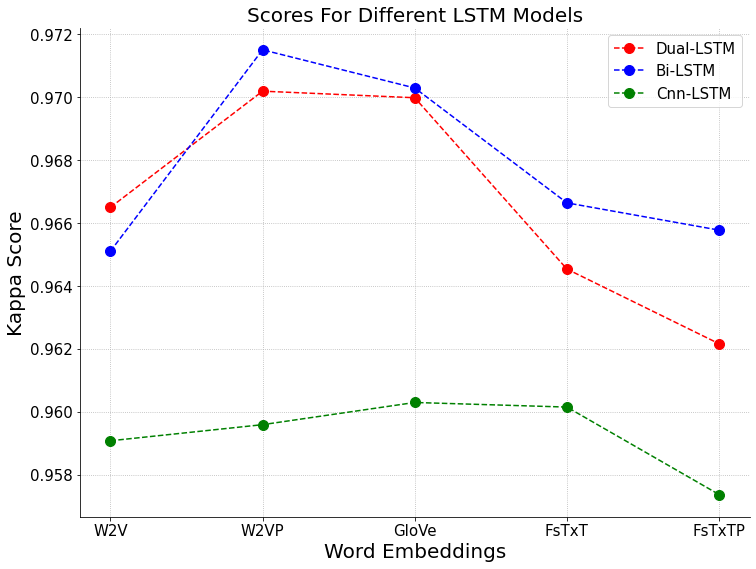

In [31]:
scoreDb = pd.DataFrame(final)

print('\nFinal Scores Matrix: \n')
print(scoreDb)
print()
plt.figure(figsize=(12,9))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Word Embeddings",size=20)
plt.ylabel("Kappa Score",size=20)
plt.title("Scores For Different LSTM Models",size=20)
color = ['red','blue','green']
plt.grid(True, linestyle=':')
plt.tick_params(labelsize=15)
for i in range(3):
    plt.plot(scoreDb.columns.values,scoreDb.iloc[i].values,color=color[i], marker='o', linestyle='--', markersize=10)
plt.legend(scoreDb.index.values, fontsize =15)
plt.show()

## Implementing Multinomial Naive Bayes from Scratch
Implementing multinomial naive bayes on the basic of word frequency count considering only top 3000 frequent words in the whole corpus.


In [32]:
import math as ma
import itertools # this is to slice the dictionary to get only max frequecvy values
from nltk.tokenize import word_tokenize # used to tokenize the sentences
stop_words = set(stopwords.words('english'))

def probability(dictionary,x,score): # it returns the actual probability of input x over class clas

    count = ma.log(dictionary[score]["count"]) - ma.log(dictionary["total"]) # it is probability for a certain score
    features_number = len(dictionary[score].keys()) - 2 # total number of features
    for j in range(features_number): # calculting the probabilty over each feature the later we will take log() sum of all       
        
        if(x[j]==0): # if input x have zero frequency over the feature so its probability will not counted
            continue
        
        count_xj_in_feature_j = dictionary[score][j] + 1 # it is the total frequency of feature j in a score
        # adding one to eliminate any domain specific errors
        count_clas_ele_in_feature = dictionary[score]["Grand_total"] # it is total number of words in a score
        p = ma.log(count_xj_in_feature_j) - ma.log(count_clas_ele_in_feature) 
        # summing all small probabilities of all features
        count = count + p
    return count # returning the probabilty

def singlecol(dictionary,x): # singlecol gives the prediction(output) of single colum at a time
    
    best_prob = -1 # giving any value to initialise best_prob
    best_cls = -1 # giving any value to initialise best_cls
    classes = dictionary.keys() # dictionary .keys have all the classes names
    val = True
    for clas in classes: # checking probabily on one class at a time 
        
        if (clas=="total"): # total is not a class so ignore it
            continue
        
        clas_p = probability(dictionary,x,clas) # clas_p will have probability of input x for class clas
        
        if(val or clas_p>best_prob):
            best_prob = clas_p
            best_cls = clas
        
        val = False
    return best_cls

X_naive = X['essay'].tolist()
Y_naive = X['domain1_score'].tolist()
sets = X['essay_set'].tolist()

# normalizing score
for i in range(len(sets)):
    Y_naive[i] = Y_naive[i] - minimum_scores[sets[i]]
    Y_naive[i] = int(np.around((Y_naive[i] * 5) / (maximum_scores[sets[i]] - minimum_scores[sets[i]])))

# doing hold out spliting for train and test data
xtrain,xtest,ytrain,ytest = train_test_split(X_naive,Y_naive,test_size=0.3,random_state=0)

len_data = len(xtrain)

# in this dictionary we will store frequency of each word from entire dataset by removing stop_words
dictionary = dict()
for j in range(len_data):
    data = xtrain[j]
    word_tokens = word_tokenize(data)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    
    for word in filtered_sentence:
        if word in dictionary:
            dictionary[word]+=1
        else:
            dictionary[word]=1

new_dict={} # this is the reverse sorted form of dictionary used above
for key,value in sorted(dictionary.items(),key=lambda item: item[1],reverse=True):
    new_dict[key]=value

# slicing over bigger ditionary to get max  frequency 3000 data only
a=dict(itertools.islice(new_dict.items(),3000))
     
features=[] # features is the list of keys of dictionary (a) 
for i in a.keys():
    features.append(i)

# modifing x_train and x_test to 2d Lists having frequency of each word of features 
xx_train=np.zeros((len(xtrain),len(features)))
for i in range(len(xtrain)):
    data=xtrain[i]
    
    word_tokens = word_tokenize(data)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    for j in filtered_sentence:
        if j in features:
            xx_train[i][features.index(j)]+=1
            
xx_test=np.zeros((len(xtest),len(features)))
for i in range(len(xtest)):
    data2 = xtest[i]
    word_tok = word_tokenize(data2)
    
    fil_sentence = [w for w in word_tok if not w in stop_words]
    
    for j in fil_sentence:
        if j in features:
            xx_test[i][features.index(j)]+=1

# this is to train algorithm over training data
result = {} # we will use dictionary and create nested dictionary where needed
classes = set(ytrain)

for current_class in classes: # accessing all score classes one by one 
    x_train_current = []   
    y_train_current = []
    result[current_class] = {}
    result["total"] = len(xx_train) # it will hold length of entire xx_train set
    for i in range(len(ytrain)):

        if (Y_naive[i]==current_class):
            x_train_current.append(xx_train[i])
            y_train_current = Y_naive[i] # spliting y_train for only current_class
    
    result[current_class]["count"] = len(x_train_current) # it will hold count of current_class
    features_total = xx_train.shape[1] # feature size is nothin but the columns of xx_train
    a = 0
    for j in range(len(features)):
        result[current_class][j]=0
        for k in range(len(x_train_current)):
            result[current_class][j] += x_train_current[k][j] # it will hold frequency of feature j
        a += result[current_class][j]
    result[current_class]["Grand_total"] = a  # it will hold count of entire words in current_class
    
ypred = []
for x in xx_test: # going through test_data row wise
    pred=singlecol(result,x) # as we get a answer by one column we are appending it to list
    ypred.append(pred)    

from sklearn.metrics import classification_report,confusion_matrix
#importing these to check correctness of y_pred(output)
print('\nThis classification is due to our implementation\n')
print(classification_report(ytest,ypred))
print('\n---------------------COMPARISION---------------------\n')
print('\nThis classification is due to sklearn library\n')

from sklearn.naive_bayes import MultinomialNB # now doing the same fit and predict by MultinomialNB library function
arg1=MultinomialNB()
arg1.fit(xx_train,ytrain)
ypred2=arg1.predict(xx_test)

print(classification_report(ytest,ypred2))


This classification is due to our implementation

              precision    recall  f1-score   support

           0       0.00      0.02      0.01       124
           1       0.04      0.13      0.06       235
           2       0.41      0.24      0.30      1188
           3       0.18      0.13      0.15      1138
           4       0.12      0.06      0.08       793
           5       0.07      0.06      0.07       415

    accuracy                           0.14      3893
   macro avg       0.14      0.11      0.11      3893
weighted avg       0.21      0.14      0.16      3893


---------------------COMPARISION---------------------


This classification is due to sklearn library

              precision    recall  f1-score   support

           0       0.17      0.61      0.27       124
           1       0.35      0.41      0.38       235
           2       0.48      0.19      0.28      1188
           3       0.53      0.42      0.47      1138
           4       0.48      0.

## Confusion Matrix for Naive Bayes 
The brighter colors and higher value number around the diagonal shows the accuracy of our model and dispersion shows the low precision.

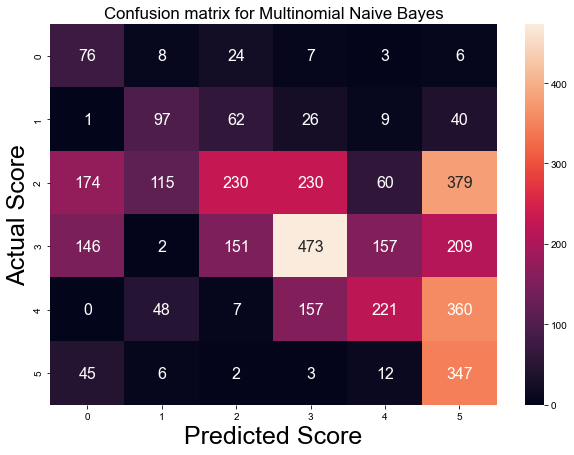

In [33]:
import seaborn as sns # for seaborn 

plt.figure(figsize=(10,7))
array = confusion_matrix(ytest,ypred2)
df_cm = pd.DataFrame(array, range(6), range(6))
fig = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d') # font size
sns.set(font_scale=1.4) # for label size
plt.xlabel("Predicted Score", size=25)
plt.ylabel("Actual Score", size=25)
plt.tick_params(labelsize=10)
plt.title("Confusion matrix for Multinomial Naive Bayes")
plt.show(fig)